## Lightgbmモデル
<br>



----

#### メモ  

**評価指標**：スピアマンの順位相関係数(Spearman's correlation coefficient)  
 

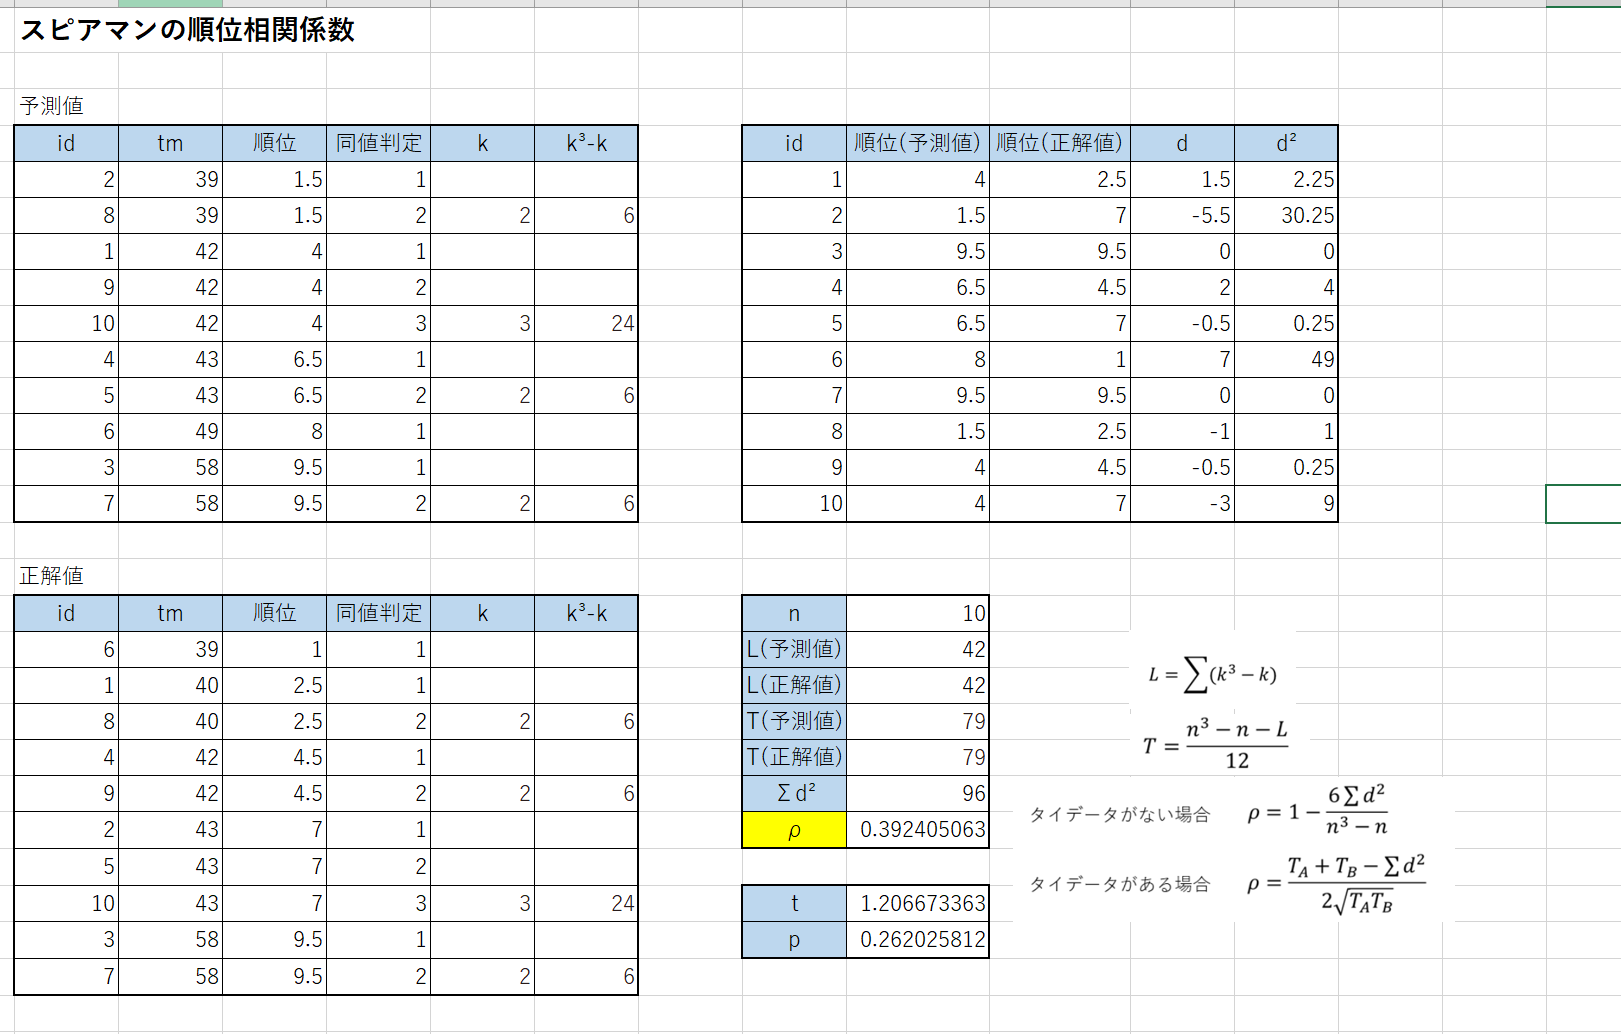
  
  
  






参考URL：  
コードや進め方,データ等  
CHRIS DEOTTEさん([@Chris Deotte](https://www.kaggle.com/cdeotte))のノート：https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/discussion/358320  
https://www.kaggle.com/code/cdeotte/xgboost-5000-mutations-200-pdb-files-lb-0-410#Transform-Train-Data  

スピアマンの順位相関係数の求め方  
参考URL:https://corvus-window.com/all_spearmans-rank-correlation/#:~:text=%E3%82%B9%E3%83%94%E3%82%A2%E3%83%9E%E3%83%B3%E3%81%AE%E9%A0%86%E4%BD%8D%E7%9B%B8%E9%96%A2%E4%BF%82%E6%95%B0%E3%81%AF%EF%BC%8C%2D1%E3%81%8B%E3%82%891,%E3%81%82%E3%82%8B%E3%81%A8%E5%88%A4%E5%AE%9A%E3%81%97%E3%81%BE%E3%81%99%EF%BC%8E  

Wildtypeを組み込んだ訓練データの作成  
作成URL：https://www.kaggle.com/code/roberthatch/novo-train-data-contains-wildtype-groups/notebook

# 訓練データとホールドアウトデータの作成
ターゲットをランク正規化して、モデルが異なるソース(ProteinDataBankからか、AlphaFoldからのデータか)からのデータでトレーニングできるようにし、すべてのターゲットがモデルにとって類似した形になるようにする。

In [1]:
import os, numpy as np, gc, seaborn as sns
from scipy.stats import spearmanr, pearsonr, rankdata
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)

train = pd.read_csv('../input/novozymes-train-test-data/kaggle_train_a.csv')
train.head()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,WT,MUT,position,relative_position,Molecular Weight_1,Molecular Weight_2,Molecular Weight_delta,Residue Weight_1,Residue Weight_2,Residue Weight_delta,pKa1_1,pKa1_2,pKa1_delta,pKb2_1,pKb2_2,pKb2_delta,pKx3_1,pKx3_2,pKx3_delta,pl4_1,pl4_2,pl4_delta,H_1,H_2,H_delta,VSC_1,VSC_2,VSC_delta,P1_1,P1_2,P1_delta,P2_1,P2_2,P2_delta,SASA_1,SASA_2,SASA_delta,NCISC_1,NCISC_2,NCISC_delta,prev,post,cos_angle,location3d,pca_pool_0,pca_wt_0,pca_mutant_0,pca_local_0,pca_pool_1,pca_wt_1,pca_mutant_1,pca_local_1,pca_pool_2,pca_wt_2,pca_mutant_2,pca_local_2,pca_pool_3,pca_wt_3,pca_mutant_3,pca_local_3,pca_pool_4,pca_wt_4,pca_mutant_4,pca_local_4,pca_pool_5,pca_wt_5,pca_mutant_5,pca_local_5,pca_pool_6,pca_wt_6,pca_mutant_6,pca_local_6,pca_pool_7,pca_wt_7,pca_mutant_7,pca_local_7,pca_pool_8,pca_wt_8,pca_mutant_8,pca_local_8,pca_pool_9,pca_wt_9,pca_mutant_9,pca_local_9,pca_pool_10,pca_wt_10,pca_mutant_10,pca_local_10,pca_pool_11,pca_wt_11,pca_mutant_11,pca_local_11,pca_pool_12,pca_wt_12,pca_mutant_12,pca_local_12,pca_pool_13,pca_wt_13,pca_mutant_13,pca_local_13,pca_pool_14,pca_wt_14,pca_mutant_14,pca_local_14,pca_pool_15,pca_wt_15,pca_mutant_15,pca_local_15,pca_pool_16,pca_pool_17,pca_pool_18,pca_pool_19,pca_pool_20,pca_pool_21,pca_pool_22,pca_pool_23,pca_pool_24,pca_pool_25,pca_pool_26,pca_pool_27,pca_pool_28,pca_pool_29,pca_pool_30,pca_pool_31,mut_prob,mut_entropy,sa_total,sa_apolar,sa_backbone,sa_sidechain,sa_ratio,sa_in/out,AA1,AA2,AA3,AA4,ddG,dTm,pdb,source,target
0,H,A,1,0.010204,155.16,89.10,-66.06,137.14,71.08,-66.06,1.82,2.34,0.52,9.17,9.69,0.52,6.00,NaN,NaN,7.59,6.00,-1.59,-0.40,0.62,1.02,79.0,27.5,-51.5,10.4,8.1,-2.3,0.230,0.046,-0.184,2.025,1.181,-0.844,-0.010690,0.007187,0.017877,X,Q,-2.000000,428.159734,-0.059648,-1.754530,-1.843776,-0.089245,-0.031326,-0.189210,-0.209619,-0.020409,0.014654,0.536634,0.061360,-0.475274,-0.017990,-0.797679,-0.704645,0.093034,0.020013,0.505999,0.014830,-0.491169,0.011445,-0.730602,-1.196362,-0.465760,-0.000777,-0.072578,-0.127413,-0.054836,0.013612,-0.048890,0.327482,0.376373,-0.005022,-0.015487,-1.000611,-0.985124,-0.013676,-0.193102,-0.511855,-0.318753,0.017168,-0.210593,-0.135689,0.074905,-0.006615,-0.434855,0.331936,0.766791,-0.007750,0.080003,0.351614,0.271611,0.000898,0.059578,-0.047816,-0.107394,0.003684,-0.206508,-0.656930,-0.450422,-0.000147,-0.766259,-0.391850,0.374408,0.003696,0.012205,-0.008405,-0.005287,-0.009110,0.003572,-0.028546,-0.006748,0.007191,0.005085,0.001616,-0.006475,0.006053,-0.016394,-0.002549,0.009162,0.022294,1.767244,161.56,110.83,40.10,121.46,78.6,0,6,0,20,13,0.5,NaN,1AJ3,jin_train.csv,0.962121
1,H,G,1,0.010204,155.16,75.07,-80.09,137.14,57.05,-80.09,1.82,2.34,0.52,9.17,9.60,0.43,6.00,NaN,NaN,7.59,5.97,-1.62,-0.40,0.48,0.88,79.0,0.0,-79.0,10.4,9.0,-1.4,0.230,0.000,-0.230,2.025,0.881,-1.144,-0.010690,0.179052,0.189742,X,Q,-2.000000,428.159734,-0.070259,-1.754530,-2.067700,-0.313170,-0.006980,-0.189210,0.114316,0.303526,0.010339,0.536634,0.455916,-0.080718,-0.011585,-0.797679,-0.431113,0.366566,0.021345,0.505999,0.341101,-0.164898,0.013375,-0.730602,-0.735969,-0.005367,0.001847,-0.072578,-0.060297,0.012280,0.011427,-0.048890,0.694839,0.743729,-0.004418,-0.015487,0.715649,0.731136,-0.003320,-0.193102,-0.791990,-0.598888,0.009986,-0.210593,0.147175,0.357768,0.003154,-0.434855,-0.262959,0.171896,-0.009184,0.080003,-0.134360,-0.214363,0.009092,0.059578,-0.078574,-0.138153,0.002819,-0.206508,0.194596,0.401103,0.002147,-0.766259,-0.600835,0.165423,0.006882,0.008652,-0.020673,-0.000738,-0.003549,-0.015015,-0.023404,-0.002193,-0.007907,0.003839,0.015505,-0.000716,0.003207,-0.004825,-0.008340,0.009910,0.012239,1.767244,161.56,110.83,40.10,121.46,78.6,0,6,5,20,13,-0.5,NaN,1AJ3,jin_train.csv,0.590909
2,F,A,3,0.030612,165.19,89.10,-76.09,147.18,71.08,-76.10,1.83,2.34,0.51,9.13,9.69,0.56,NaN,NaN,NaN,5.48,6.00,0.52,1.19,0.62,-0.57,115.5,27.5,-88.0,5.2,8.1,2.9,0.290,0.046,-0.244,2.228,1.181,-1.047,0.037552,0.007187,-0.030365,Q,F,-0.133476,272.373475,-0.068369,1.546457,0.492206,-1.054251,0.0116

In [2]:
KFOLD_SOURCES = ['jin_tm.csv','jin_train.csv','jin_test.csv']
HOLDOUT_SOURCES = ['kaggle.csv']
EXCLUDE_CT_UNDER = 25
USE_PLDDT_INFER = False
USE_B_COLUMN = False

In [3]:
holdout = train.loc[train.source.isin(HOLDOUT_SOURCES)].reset_index(drop=True) # HOLDOUT_SOURCESに含まれるソースを持つ行を抽出
train = train.loc[train.source.isin(KFOLD_SOURCES)].reset_index(drop=True) # FOLD_SOURCESに含まれるソースを持つ行を抽出

#　グループKフォールドのために、グループをラベルエンコード
train['group'],_ = train.pdb.factorize()
holdout['group'],_ = holdout.pdb.factorize()

In [4]:
EXCLUDE = ['WT','MUT','prev','post','ddG','dTm','pdb','source','target','group','oof'] # 特徴量から除外
FEATURES = [c for c in train.columns if c not in EXCLUDE]
print(f'We have {len(FEATURES)} features for our model:')
print( FEATURES )

We have 132 features for our model:
['position', 'relative_position', 'Molecular Weight_1', 'Molecular Weight_2', 'Molecular Weight_delta', 'Residue Weight_1', 'Residue Weight_2', 'Residue Weight_delta', 'pKa1_1', 'pKa1_2', 'pKa1_delta', 'pKb2_1', 'pKb2_2', 'pKb2_delta', 'pKx3_1', 'pKx3_2', 'pKx3_delta', 'pl4_1', 'pl4_2', 'pl4_delta', 'H_1', 'H_2', 'H_delta', 'VSC_1', 'VSC_2', 'VSC_delta', 'P1_1', 'P1_2', 'P1_delta', 'P2_1', 'P2_2', 'P2_delta', 'SASA_1', 'SASA_2', 'SASA_delta', 'NCISC_1', 'NCISC_2', 'NCISC_delta', 'cos_angle', 'location3d', 'pca_pool_0', 'pca_wt_0', 'pca_mutant_0', 'pca_local_0', 'pca_pool_1', 'pca_wt_1', 'pca_mutant_1', 'pca_local_1', 'pca_pool_2', 'pca_wt_2', 'pca_mutant_2', 'pca_local_2', 'pca_pool_3', 'pca_wt_3', 'pca_mutant_3', 'pca_local_3', 'pca_pool_4', 'pca_wt_4', 'pca_mutant_4', 'pca_local_4', 'pca_pool_5', 'pca_wt_5', 'pca_mutant_5', 'pca_local_5', 'pca_pool_6', 'pca_wt_6', 'pca_mutant_6', 'pca_local_6', 'pca_pool_7', 'pca_wt_7', 'pca_mutant_7', 'pca_local_7

# lightgbm Model

## グリッドサーチ

In [5]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

X_train = train[FEATURES]
y_train = train['target']

param_grid = {
    'num_leaves': [16, 32, 64],
    'learning_rate': [0.1, 0.01, 0.001],
    'feature_fraction': [0.8, 0.9],
    'bagging_fraction': [0.8, 0.9],
    'bagging_freq': [5, 10],
}

# LightGBMモデルの定義（チューニングしたいパラメータ以外は固定）
model = lgb.LGBMRegressor(objective='regression', metric='rmse', verbose=0)

# GridSearchCVオブジェクトの作成
grid_search = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', cv=5)

# グリッドサーチの実行
grid_search.fit(X_train, y_train)

# 最適なハイパーパラメータの取得
best_params = grid_search.best_params_
print("Best parameters:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)

del X_train, y_train, model
_ = gc.collect() #さらにメモリの開放

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] bagging_fraction is set=0.8, subsamp

In [6]:
print("Best parameters:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)

Best parameters: {'bagging_fraction': 0.8, 'bagging_freq': 5, 'feature_fraction': 0.9, 'learning_rate': 0.1, 'num_leaves': 16}
Best score: 0.24464663316090904


In [7]:
# LOAD XGB LIBRARY
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
print('lightgbm Version',lgb.__version__)

FOLDS = 11
SEED = 123

# lightgbm MODEL PARAMETERS
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 16,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

lightgbm Version 3.3.2


In [8]:
%%time
importances = []
importances2 = []
oof = np.zeros(len(train))
preds = np.zeros(len(holdout))
os.system('mkdir lgb_models')

skf = GroupKFold(n_splits=FOLDS)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train.target, train.group)):

    print('#'*25)
    print('### Fold', fold+1)
    print('### Train size', len(train_idx), 'Valid size', len(valid_idx))
    print('#'*25)

    # TRAIN, VALID, HOLDOUT FOR FOLD K
    X_train = train.loc[train_idx, FEATURES].values
    y_train = train.loc[train_idx, 'target'].values
    X_valid = train.loc[valid_idx, FEATURES].values
    y_valid = train.loc[valid_idx, 'target'].values
    X_holdout = holdout[FEATURES].values

    # TRAIN MODEL FOLD K
    model = lgb.train(params,
                      lgb.Dataset(X_train, label=y_train),
                      valid_sets=[lgb.Dataset(X_train, label=y_train), lgb.Dataset(X_valid, label=y_valid)],
                      num_boost_round=100,
                      early_stopping_rounds=10,
                      verbose_eval=10)

    model.save_model(f'lgb_models/LGB_fold{fold}.lgb')

    # GET FEATURE IMPORTANCE FOR FOLD K
    dd = dict(zip(FEATURES, model.feature_importance()))
    df = pd.DataFrame({'feature': dd.keys(), f'importance_{fold}': dd.values()})
    importances.append(df)
    dd = dict(zip(FEATURES, model.feature_importance(importance_type='gain')))
    df = pd.DataFrame({'feature': dd.keys(), f'importance_{fold}': dd.values()})
    importances2.append(df)

    # INFER OOF FOLD K
    oof_preds = model.predict(X_valid)
    rsme = mean_squared_error(y_valid, oof_preds, squared=False)
    print('RSME =', rsme, '\n')
    oof[valid_idx] = oof_preds

    # フォールドアウトデータの検証。各フォールドの予測結果を平均化して最終的なホールドアウトデータの予測結果を得る
    if len(holdout) > 0:
        p = model.predict(X_holdout)
        preds += p / FOLDS

    del X_train, y_train, X_valid, y_valid, model
    _ = gc.collect() #さらにメモリの開放

# モデルの訓練データに対する精度の評価
print('#'*25)
rsme = mean_squared_error(train.target, oof, squared=False)
print('OVERALL RSME =', rsme, '\n')

train['oof'] = oof
if len(holdout)>0: holdout['preds'] = preds # holdoutデータがあれば、予測結果を追加

#########################
### Fold 1
### Train size 3241 Valid size 526
#########################
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005956 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 0.239888	valid_1's rmse: 0.237183


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's rmse: 0.217444	valid_1's rmse: 0.223547
[30]	valid_0's rmse: 0.202258	valid_1's rmse: 0.218997
[40]	valid_0's rmse: 0.190161	valid_1's rmse: 0.217031
[50]	valid_0's rmse: 0.179938	valid_1's rmse: 0.215805
[60]	valid_0's rmse: 0.171876	valid_1's rmse: 0.215343
[70]	valid_0's rmse: 0.164306	valid_1's rmse: 0.21474
Early stopping, best iteration is:
[66]	valid_0's rmse: 0.167319	valid_1's rmse: 0.214222
RSME = 0.21422230306876547 

#########################
### Fold 2
### Train size 3439 Valid size 328
#########################
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006115 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 0.238946	valid_1's rmse: 0.240781


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's rmse: 0.216586	valid_1's rmse: 0.222942
[30]	valid_0's rmse: 0.201203	valid_1's rmse: 0.215013
[40]	valid_0's rmse: 0.189858	valid_1's rmse: 0.211549
Early stopping, best iteration is:
[38]	valid_0's rmse: 0.192026	valid_1's rmse: 0.210032
RSME = 0.21003208570662507 

#########################
### Fold 3
### Train size 3438 Valid size 329
#########################
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006014 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 0.234834	valid_1's rmse: 0.276892


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's rmse: 0.21236	valid_1's rmse: 0.278857
Early stopping, best iteration is:
[14]	valid_0's rmse: 0.224266	valid_1's rmse: 0.275991
RSME = 0.27599056328381 

#########################
### Fold 4
### Train size 3461 Valid size 306
#########################


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006697 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 0.237636	valid_1's rmse: 0.248311
[20]	valid_0's rmse: 0.215003	valid_1's rmse: 0.236366
[30]	valid_0's rmse: 0.199785	valid_1's rmse: 0.233289
[40]	valid_0's rmse: 0.187753	valid_1's rmse: 0.232359
[50]	valid_0's rmse: 0.178335	valid_1's rmse: 0.231244
[60]	valid_0's rmse: 0.170198	valid_1's rmse: 0.233612
Early stopping, best iteration is:
[50]	valid_0's rmse: 0.178335	valid_1's rmse: 0.231244
RSME = 0.23124364862832147 

#########################
### Fold 5
### Train size 3436 Valid size 331
#########################
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006109 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 10 rounds
[

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[6]	valid_0's rmse: 0.248562	valid_1's rmse: 0.27743
RSME = 0.277429616145976 

#########################
### Fold 6
### Train size 3437 Valid size 330
#########################


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006705 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 0.234865	valid_1's rmse: 0.271162
[20]	valid_0's rmse: 0.210838	valid_1's rmse: 0.269371
[30]	valid_0's rmse: 0.195592	valid_1's rmse: 0.269935
Early stopping, best iteration is:
[22]	valid_0's rmse: 0.207038	valid_1's rmse: 0.268201
RSME = 0.2682013798421704 

#########################
### Fold 7
### Train size 3455 Valid size 312
#########################


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006194 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 0.237948	valid_1's rmse: 0.24542
[20]	valid_0's rmse: 0.214873	valid_1's rmse: 0.235955
[30]	valid_0's rmse: 0.199002	valid_1's rmse: 0.232014
Early stopping, best iteration is:
[29]	valid_0's rmse: 0.200412	valid_1's rmse: 0.231401
RSME = 0.2314007295565702 

#########################
### Fold 8
### Train size 3453 Valid size 314
#########################
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006303 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 0.238167	valid_1's rmse: 0.243457


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's rmse: 0.214764	valid_1's rmse: 0.234378
[30]	valid_0's rmse: 0.200074	valid_1's rmse: 0.232082
Early stopping, best iteration is:
[29]	valid_0's rmse: 0.201291	valid_1's rmse: 0.231929
RSME = 0.23192908661853753 

#########################
### Fold 9
### Train size 3437 Valid size 330
#########################
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006083 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 0.236998	valid_1's rmse: 0.252304


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's rmse: 0.213712	valid_1's rmse: 0.242118
[30]	valid_0's rmse: 0.199126	valid_1's rmse: 0.23685
[40]	valid_0's rmse: 0.188117	valid_1's rmse: 0.236564
[50]	valid_0's rmse: 0.17893	valid_1's rmse: 0.234645
[60]	valid_0's rmse: 0.170603	valid_1's rmse: 0.234783
Early stopping, best iteration is:
[52]	valid_0's rmse: 0.177218	valid_1's rmse: 0.233984
RSME = 0.2339835302144465 

#########################
### Fold 10
### Train size 3436 Valid size 331
#########################


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006320 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 0.236479	valid_1's rmse: 0.259388
[20]	valid_0's rmse: 0.213562	valid_1's rmse: 0.25103
[30]	valid_0's rmse: 0.198527	valid_1's rmse: 0.247917
[40]	valid_0's rmse: 0.18705	valid_1's rmse: 0.246709
[50]	valid_0's rmse: 0.178101	valid_1's rmse: 0.246114
[60]	valid_0's rmse: 0.169496	valid_1's rmse: 0.247508
Early stopping, best iteration is:
[53]	valid_0's rmse: 0.175434	valid_1's rmse: 0.245893
RSME = 0.24589319460337455 

#########################
### Fold 11
### Train size 3437 Valid size 330
#########################


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.169867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 0.236695	valid_1's rmse: 0.252079
[20]	valid_0's rmse: 0.213103	valid_1's rmse: 0.242294
[30]	valid_0's rmse: 0.19836	valid_1's rmse: 0.238867
[40]	valid_0's rmse: 0.186724	valid_1's rmse: 0.238344
[50]	valid_0's rmse: 0.177251	valid_1's rmse: 0.23801
Early stopping, best iteration is:
[48]	valid_0's rmse: 0.178876	valid_1's rmse: 0.237637
RSME = 0.2376369244655608 

#########################
OVERALL RSME = 0.2414217289061862 

CPU times: user 11.8 s, sys: 87.7 ms, total: 11.9 s
Wall time: 7.27 s


# 各特徴量の重要度
`weight` と `gain`による特徴の重要度の算定

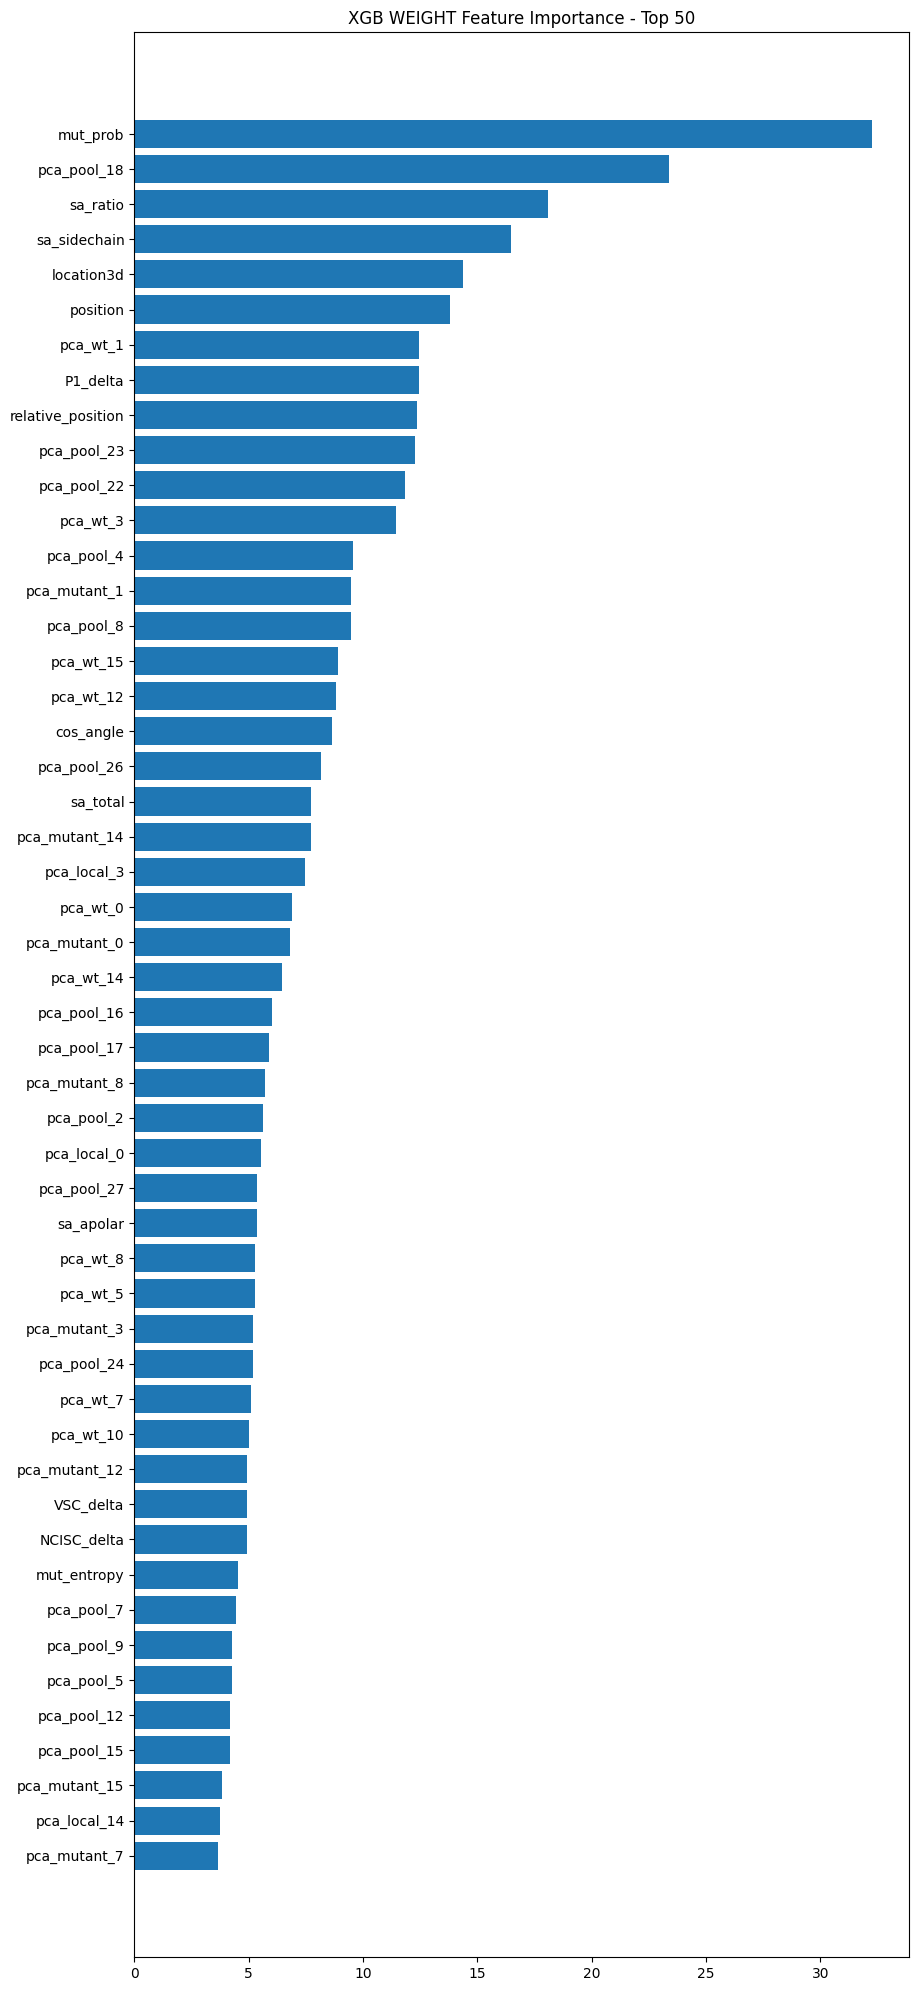

In [9]:
df = importances[0].copy() # 最初の特徴量をコピー
for k in range(1,FOLDS): df = df.merge(importances[k], on='feature', how='left') # featureをキーにして各Foldでのimportanceを追加していく。
df['importance'] = df.iloc[:,1:].mean(axis=1) # 2列目からのimportanceの平均値を計算し、列追加で値を格納
df = df.sort_values('importance',ascending=False) # importanceを降順に変更
NUM_FEATURES = 50 #len(df)
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES]) # 水平方向の棒グラフ
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES]) # 特徴量の名前を記載
plt.title(f'XGB WEIGHT Feature Importance - Top {NUM_FEATURES}')
plt.show()

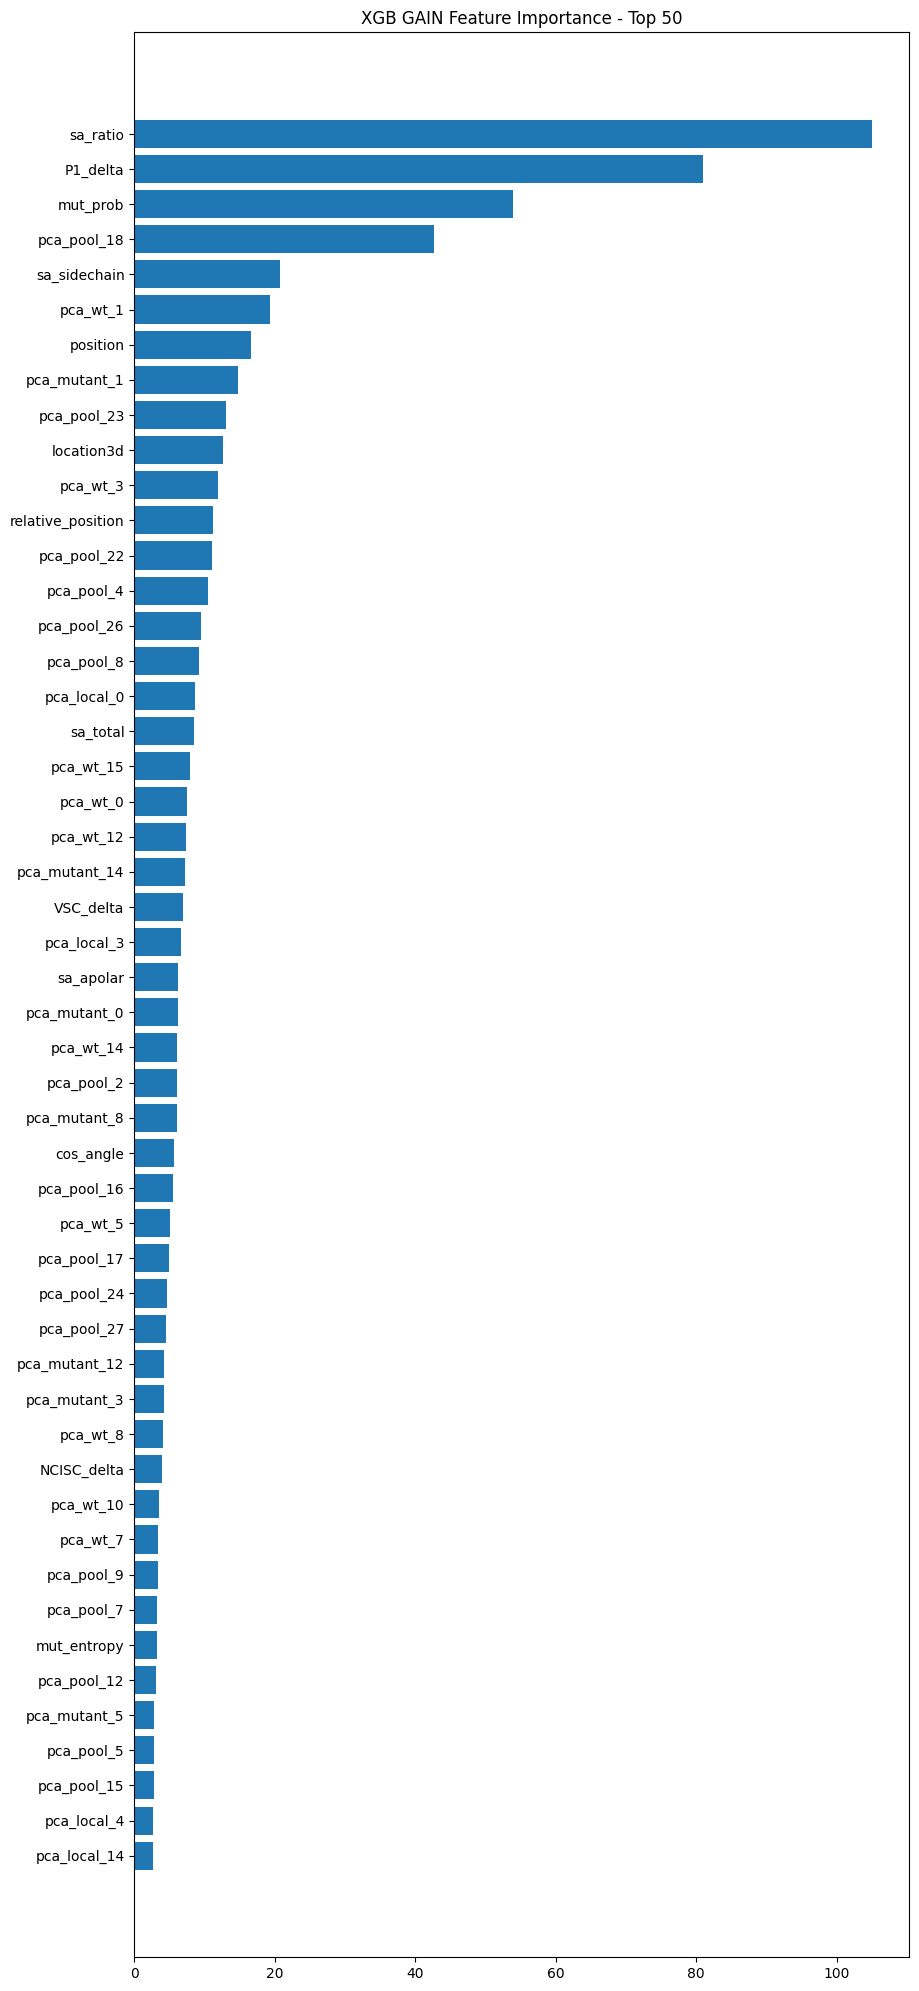

In [10]:
df = importances2[0].copy()
for k in range(1,FOLDS): df = df.merge(importances2[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1)
df = df.sort_values('importance',ascending=False)
NUM_FEATURES = 50 #len(df)
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'XGB GAIN Feature Importance - Top {NUM_FEATURES}')
plt.show()

# OOF(交差検証)の精度 

In [11]:
sp = []; sp_dtm = []; sp_ddg = []
for p in train.pdb.unique():

    tmp = train.loc[train.pdb==p].reset_index(drop=True) # PDB毎に値を格納
    ttarget = 'dTm'
    if tmp['dTm'].isna().sum()>len(tmp)/2: ttarget = 'ddG' # dTmがNaN（欠損値）の数がデータの半数以上である場合は、ターゲットをddGに設定
    print('Protein',p,'has mutation count =',len(tmp),'and target =',ttarget) 
    r = np.abs( spearmanr(tmp.oof.values, tmp[ttarget].values).correlation ) # 予測値oofと正解値のスピアマン相関係数を算出
    print('Spearman Metric =',r)
    sp.append(r)
    if ttarget=='dTm': sp_dtm.append(r)
    else: sp_ddg.append(r)
    print()

print('#'*25)
if len(sp_dtm)>0: # dTmのスピアマン相関係数の平均値
    print(f'Overall Spearman Metric (predicting dTm) =',np.nanmean(sp_dtm))
if len(sp_ddg)>0: # ddGのスピアマン相関係数の平均値
    print(f'Overall Spearman Metric (predicting ddG) =',np.nanmean(sp_ddg))

Protein 1AJ3 has mutation count = 66 and target = ddG
Spearman Metric = 0.6736300621236709

Protein 1APS has mutation count = 27 and target = ddG
Spearman Metric = 0.5851275617739256

Protein 1ARR has mutation count = 59 and target = ddG
Spearman Metric = 0.6929408615435528

Protein 1BNI has mutation count = 171 and target = ddG
Spearman Metric = 0.599976600000899

Protein 1BPI has mutation count = 66 and target = ddG
Spearman Metric = 0.811924473032127

Protein 1BU4 has mutation count = 71 and target = ddG
Spearman Metric = 0.7272635837385182

Protein 1BVC has mutation count = 73 and target = ddG
Spearman Metric = 0.6837817874843661

Protein 1CSP has mutation count = 50 and target = ddG
Spearman Metric = 0.5795097122849785

Protein 1FKJ has mutation count = 53 and target = ddG
Spearman Metric = 0.7769041596165894

Protein 1FTG has mutation count = 45 and target = ddG
Spearman Metric = 0.6018643568599905

Protein 1H7M has mutation count = 28 and target = ddG
Spearman Metric = 0.3560968

# ホールドアウトの精度

In [12]:
# 先ほどと同様にスピアマン相関係数をHoldoutデータでも算出する。
sp = []; sp_dtm = []; sp_ddg = []
for p in holdout.pdb.unique():

    tmp = holdout.loc[holdout.pdb==p].reset_index(drop=True) 
    ttarget = 'dTm'
    if tmp['dTm'].isna().sum()>len(tmp)/2: ttarget = 'ddG'
    print('Protein',p,'has mutation count =',len(tmp),'and target =',ttarget)
    r = np.abs( spearmanr(tmp.preds.values, tmp[ttarget].values).correlation )
    print('Spearman Metric =',r)
    sp.append(r)
    if ttarget=='dTm': sp_dtm.append(r)
    else: sp_ddg.append(r)
    print()

print('#'*25)
if len(sp_dtm)>0:
    print(f'Overall Spearman Metric (predicting dTm) =',np.nanmean(sp_dtm))
if len(sp_ddg)>0:
    print(f'Overall Spearman Metric (predicting ddG) =',np.nanmean(sp_ddg))

Protein GP01 has mutation count = 185 and target = dTm
Spearman Metric = 0.6643254749341989

Protein GP02 has mutation count = 211 and target = dTm
Spearman Metric = 0.7455996840392477

Protein GP06 has mutation count = 56 and target = dTm
Spearman Metric = 0.16891673192919582

Protein GP07 has mutation count = 77 and target = dTm
Spearman Metric = 0.6589811714122177

Protein GP08 has mutation count = 55 and target = dTm
Spearman Metric = 0.3385606041866366

Protein GP09 has mutation count = 30 and target = dTm
Spearman Metric = 0.8821631736641413

Protein GP10 has mutation count = 84 and target = dTm
Spearman Metric = 0.5219486135833009

Protein GP11 has mutation count = 46 and target = dTm
Spearman Metric = 0.27330348960921

Protein GP12 has mutation count = 78 and target = dTm
Spearman Metric = 0.6789892426787365

Protein GP14 has mutation count = 45 and target = dTm
Spearman Metric = 0.6454970697188769

Protein GP16 has mutation count = 33 and target = dTm
Spearman Metric = 0.80648

# テストデータを推論

In [13]:
test = pd.read_csv('../input/novozymes-train-test-data/kaggle_test_a.csv')

In [14]:
%%time
# XGB用のテストデータ
X_test = test[FEATURES].values

# XGBモデルでテストデータを推論
preds = np.zeros(len(test))
for fold in range(FOLDS):
    model = lgb.Booster(model_file=f'lgb_models/LGB_fold{fold}.lgb') # 学習の時に保存したモデルを読み込む
    preds += model.predict(X_test) # 予測値
preds /= FOLDS # 平均値

CPU times: user 158 ms, sys: 2.98 ms, total: 161 ms
Wall time: 81.9 ms


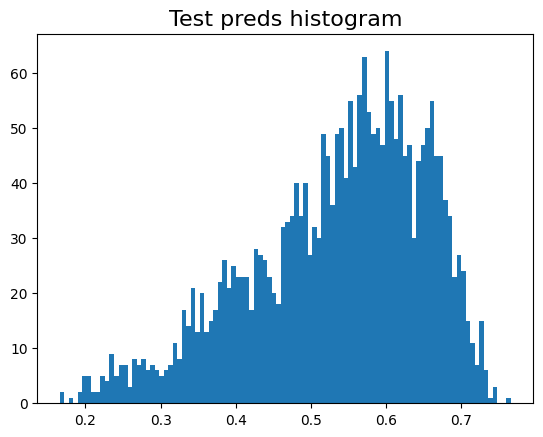

In [15]:
plt.hist(preds,bins=100)
plt.title('Test preds histogram',size=16)
plt.show()

# 提出用データを作成
テストデータには2413行ある。そのうち、77行は削除変異体(アミノ酸が減るタイプ)である。訓練済みモデルは編集変異体のみを予測できるため、削除変異体はすべて以下の編集変異体の予測の平均値に設定されます。

In [16]:
test = pd.read_csv('../input/novozymes-enzyme-stability-prediction/test.csv')
deletions = test.loc[test.protein_sequence.str.len()==220,'seq_id'].values
print('Test shape', test.shape )
test.head()

Test shape (2413, 4)


,seq_id,protein_sequence,pH,data_source
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


In [17]:
sub = pd.read_csv('../input/novozymes-enzyme-stability-prediction/sample_submission.csv')
sub.tm = preds
sub.loc[sub.seq_id.isin(deletions),'tm'] = sub.loc[~sub.seq_id.isin(deletions),'tm'].mean()
sub.to_csv('submission_single_model.csv',index=False)
sub.head()

,seq_id,tm
0,31390,0.665373
1,31391,0.643887
2,31392,0.533832
3,31393,0.708440
4,31394,0.715062
